**Задание**

Возьмите временной ряд — стационарный и не стационарный.

Приблизьте оба варианта моделями из класса MA.

Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

 Выбранные временные ряды:
 * "International airline passengers: monthly totals in thousands" (характеризуется трендом, сезонностью и цикличностью, нарастающей дисперсией);
 * Этот же ряд, приведенный к стационарности.

Выбранные модели:
* "Тройное экспоненциальное сглаживание" (TEMA) для нестационарного временного ряда, причина выбора - наличие у исходного ряда сезонности и тренда.
* Экспоненциальное сглаживание (EMA) для стационарного временного ряда, т.к. составляющих сезонности, тренда и цикличности у его нет.

# **Анализ нестационарного временного ряда**

In [204]:
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
# female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

In [205]:
airlines_passengers_series = airlines_passengers['Count']

График ряда:

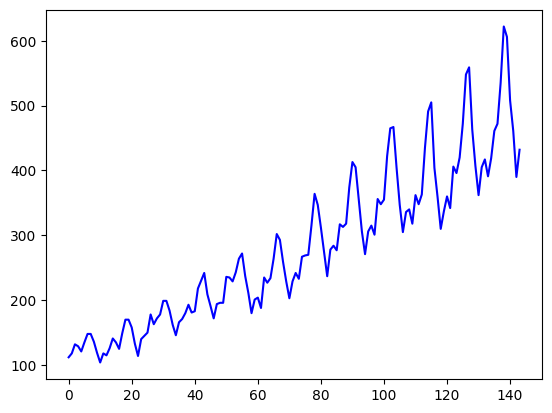

In [206]:
plt.plot(airlines_passengers_series, color='blue')

Разделение на обучающую и тестовую выборки:

In [207]:
train, test = airlines_passengers_series[:60], airlines_passengers_series[60:]

Функции для применения метода Хольта-Винтерса:

In [208]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [209]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [210]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [211]:
def plot_tema(alpha, beta, gamma, ser=airlines_passengers_series, ser_to_plot=airlines_passengers_series, n_preds=30):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

Поиск оптимальных значений коэффициентов:

In [212]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [213]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [214]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [215]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1385.5609704159897
        x: [ 2.954e-03  1.000e+00  3.918e-01]
      nit: 50
      jac: [ 2.165e+01 -1.610e+01 -1.380e-01]
     nfev: 300
     njev: 75
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


In [240]:
opt.x # оптимальные коэффициенты

array([0.00295434, 1.        , 0.39182219])

Исходный график и сглаженный с помощью тройного экспоненциального сглаживания (с полученными выше оптимальными параметрами):

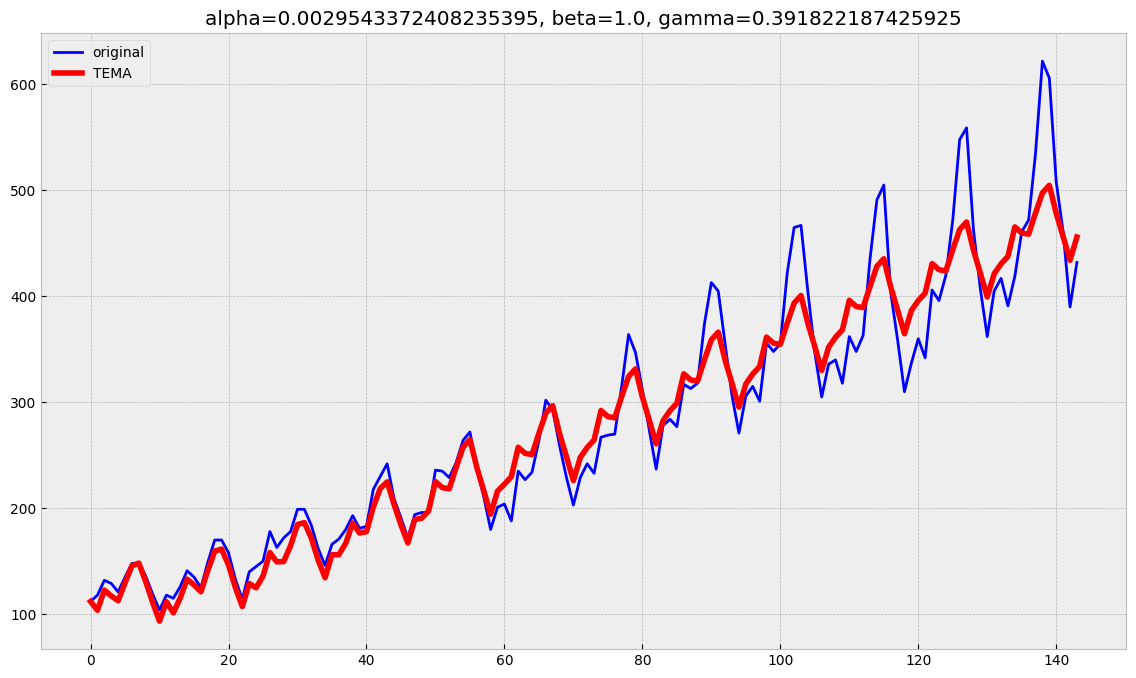

In [216]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=airlines_passengers_series, n_preds=len(test))

Из изображения видно, что на обучающей выборке ошибка была небольшой, но на тестовой выборке значительно увеличилась.

Ошибка RMSE на обучающей выборке:

In [217]:
tema_train = triple_exponential_smoothing(train, 12, alpha_opt, beta_opt, gamma_opt, 0)

In [218]:
rmse_train = mean_squared_error(train, tema_train) ** 0.5

In [219]:
rmse_train.round(3)

10.734

Ошибка RMSE на тестовой выборке:

In [220]:
tema_test = triple_exponential_smoothing(train, 12, alpha_opt, beta_opt, gamma_opt, len(test))
predictions = tema_test[-len(test):]

In [221]:
rmse_test = mean_squared_error(test, predictions) ** 0.5

In [222]:
rmse_test.round(3)

37.223

Ошибка на тестовой выборке увеличилась примерно в 3,7 раза по сравнению с ошибкой на обучающей выборке.

# **Анализ стационарного временного ряда**

Приведение к стационарности ряда "International airline passengers: monthly totals in thousands":

In [224]:
series_airline = boxcox(airlines_passengers_series, 0) # убираем нарастание дисперсии
series_airline = series_airline[1:] - series_airline[:-1] # убираем тренд
series_airline = series_airline[12:] - series_airline[:-12] # убираем годовую сезонность
series_airline = series_airline[24:] - series_airline[:-24] # убираем двухгодовую цикличность

In [225]:
series_airline = pd.Series(series_airline)

График ряда:

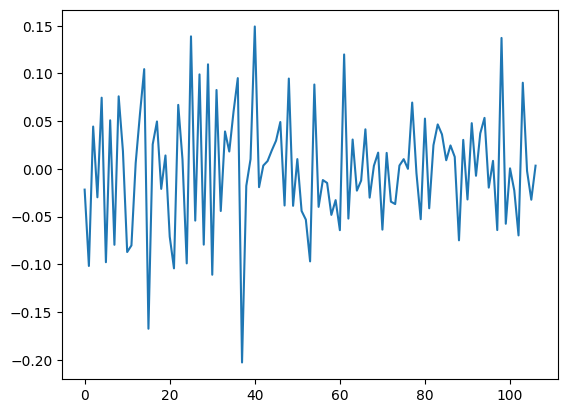

In [226]:
plt.plot(series_airline)

Т.к. рассматриваемый временной ряд стационарный, а значит, не имеет выраженных тренда, сезонности и цикличности, метод Хольта-Винтерса для его анализа не подходит. Воспользуемся экспоненциальным сглаживанием (EMA).

Разделение на обучающую и тестовую выборки:

In [227]:
train_s, test_s = series_airline[:50], series_airline[50:]

Функция для применения метода EMA:

In [228]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

Поиск оптимального значения коэффициента альфа методом наименьших квадратов:

In [229]:
from scipy.optimize import least_squares

In [230]:
def mse_s(X):
    alpha = X
    result = exponential_moving_average(train, alpha)
    error = mean_squared_error(result, train)
    return error

In [231]:
opt_s = least_squares(mse_s, x0=0.1)

In [232]:
alpha_opt_s = opt_s.x
print(opt_s)

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 1.304e-07]
           x: [ 1.000e+00]
        cost: 8.499693204090299e-15
         jac: [[-1.238e-02]]
        grad: [-1.615e-09]
  optimality: 1.6147749024163417e-09
 active_mask: [ 0.000e+00]
        nfev: 19
        njev: 19


In [233]:
alpha_opt_s # оптимальное значение

array([0.99997895])

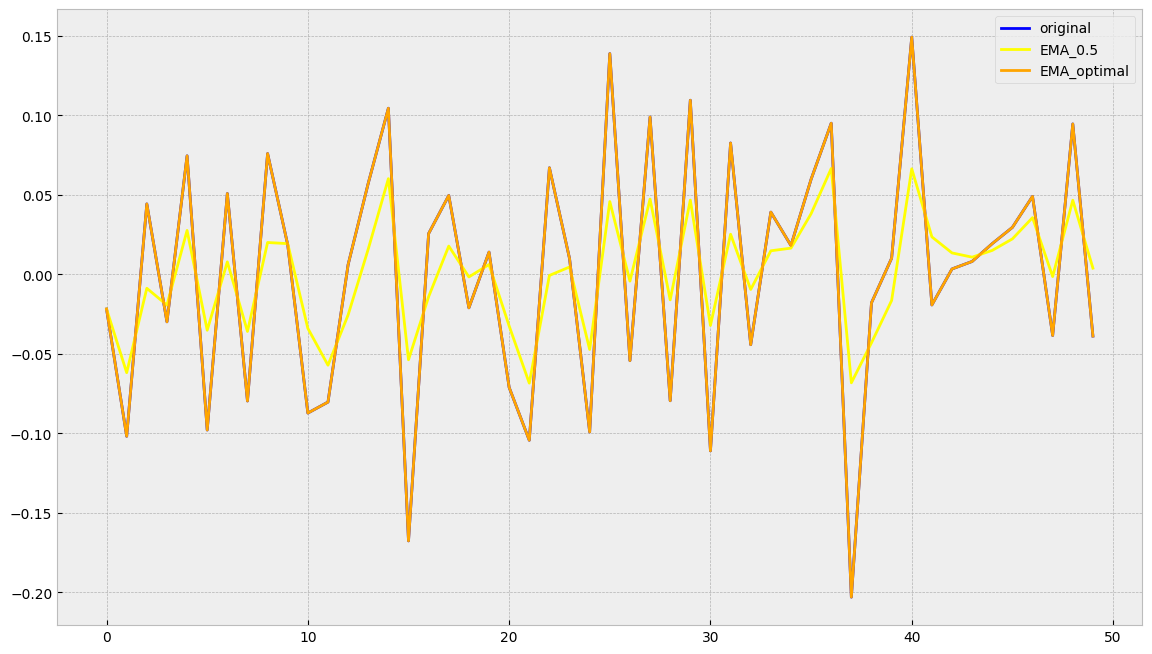

In [234]:
ema_05 = exponential_moving_average(train_s, 0.5)
ema_opt = exponential_moving_average(train_s, alpha_opt_s)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(train_s, color='blue',label='original')
    plt.plot(ema_05, color='yellow', linewidth='2', label='EMA_0.5')
    plt.plot(ema_opt, color='orange', linewidth='2', label='EMA_optimal')
    plt.legend()

По изображению выше видно, что при оптимальном значении коэффициента график EMA сливается с оригинальным.

Соответственно, ошибка RMSE на обучающей выборке равна нулю:

In [235]:
ema_train = exponential_moving_average(train_s, alpha_opt_s)

In [236]:
rmse_train_s = mean_squared_error(train_s, ema_train) ** 0.5
rmse_train_s.round(3)

0.0

Предсказание тестовых значений:

In [237]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)

    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)

    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)

Исходный график и предсказание методом EMA той части графика, которая была отведена на тест:

<ipython-input-237-6b5f8bf1ae9d>:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)


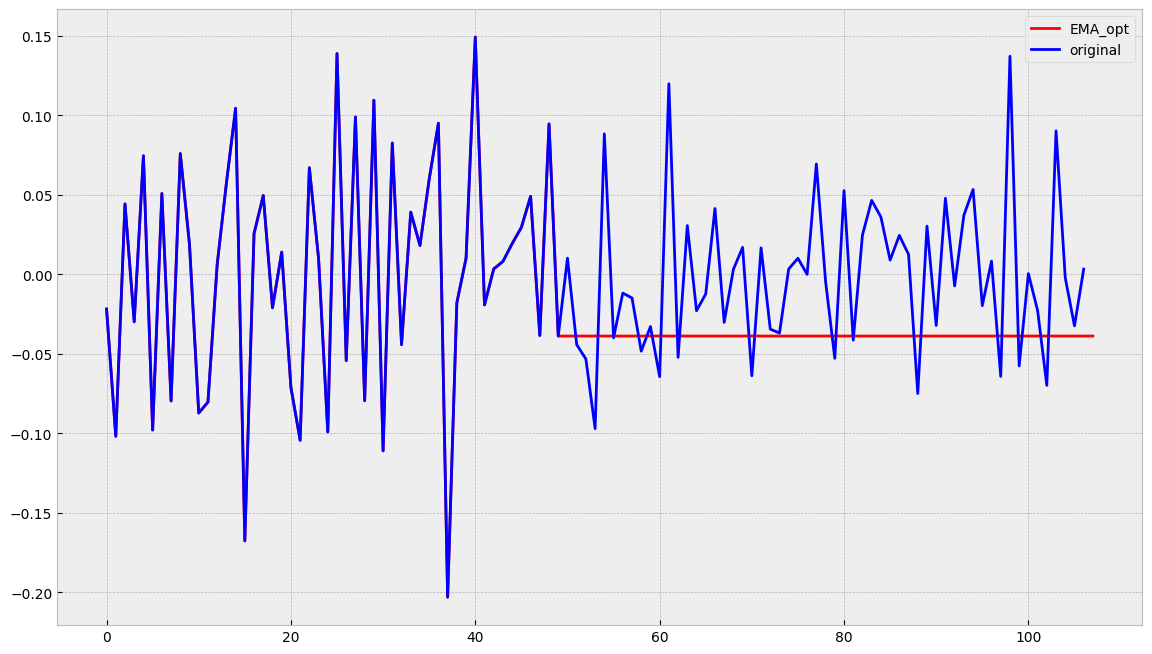

In [238]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    ser, _ = exponential_moving_average(train_s, alpha_opt_s, len(test_s))
    plt.plot(ser, color='red', linewidth='2', label='EMA_opt')
    plt.plot(series_airline, color='blue',label='original')
    plt.legend()

Т.к. временный ряд стационарный и не имеет восходящего или нисходящего тренда, метод EMA "предсказал" усредненное значение величины, отложенной по оси ординат.

Ошибка RMSE для тестовой выборки отлична от нуля:

In [239]:
rmse_test_s = mean_squared_error(test_s, ser[-len(test_s):]) ** 0.5
rmse_test_s.round(3)

0.061